# Classificação de Fraturas em Raios‑X
### Baseline com Transfer Learning (EfficientNet/ResNet) no Kaggle

**Dataset:** Bone Fracture Multi‑Region X‑ray Data (bmadushanirodrigo)  
**Autor:** Hermes Winarski  
**Data:** 06/11/2025

> EIntrodução

## Sumário
1. [Configuração do Ambiente](#sec-ambiente)  
2. [Localização do Dataset](#sec-dataset)  
3. [Transforms e Pré‑processamento](#sec-transforms)  
4. [Datasets e DataLoaders](#sec-dataloaders)  
5. [Modelo e Head de Classificação](#sec-modelo)  
6. [Loss, Otimizador e Scheduler](#sec-otimizador)  
7. [Funções de Treino e Validação](#sec-funcoes)  
8. [Treinamento (Loop de Épocas)](#sec-treino)  
9. [Checkpoint / Melhor Modelo](#sec-checkpoint)  
10. [Avaliação em Teste](#sec-teste)  
11. [Visualizações: Matriz de Confusão e ROC](#sec-plots)  
12. [Embeddings (PCA/UMAP) — opcional](#sec-embeddings)  
13. [Erros Típicos (FP/FN)](#sec-erros)  
14. [Resultados e Conclusões](#sec-conclusoes)  


## 1. Configuração do Ambiente {#sec-ambiente}

Importamos as bibliotecas necessárias e, quando aplicável, definimos `device` (CPU/GPU) e semente para reprodutibilidade.


In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


device: cuda
GPU: Tesla T4


## 5. Modelo e Head de Classificação {#sec-modelo}

Carregamos o backbone pré‑treinado (EfficientNet/ResNet) e substituímos a **camada final** por um `Linear` com 2 classes. Podemos congelar/descongelar o backbone conforme a estratégia.


In [2]:
from torchvision import models
import torch.nn as nn

NUM_CLASSES = 2

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
# substitui o classificador final
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)

# opcional: congelar backbone nas 2 primeiras épocas (warmup)
for name, p in model.features.named_parameters():
    p.requires_grad = True  # se quiser congelar inicialmente: False


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 151MB/s]


## 6. Loss, Otimizador e Scheduler {#sec-otimizador}

Configuramos a função de perda (`CrossEntropyLoss`), o otimizador (ex.: `AdamW`) e um `scheduler` (ex.: `CosineAnnealingLR`). Se a GPU estiver ativa, usamos `torch.amp` para *mixed precision*. 


In [3]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


/tmp/ipykernel_37/1653922432.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


## 2. Localização do Dataset {#sec-dataset}

Detectamos a raiz correta do dataset no Kaggle (`/kaggle/input/...`) e validamos a estrutura `train/val/test` com classes `fractured` e `not fractured`. Inclui checagens de integridade (arquivos, duplicatas).


In [26]:
import torch, random, numpy as np
from pathlib import Path

# raiz que você detectou no passo anterior:
DATA_ROOT = Path("/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification")

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## 3. Transforms e Pré‑processamento {#sec-transforms}

Definimos *augmentations* moderadas e normalização compatível com modelos pré‑treinados em ImageNet. Mantemos dimensão padrão (ex.: 224×224) para o baseline.


In [27]:
from torchvision import transforms

IMG_SIZE = 224

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=7),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_tfms = val_tfms


In [28]:
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True  # tolera arquivos incompletos
Image.MAX_IMAGE_PIXELS = None           # (seguro aqui; evita proteção contra imagens “grandes”)

In [29]:
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True  # tolera arquivos truncados
Image.MAX_IMAGE_PIXELS = None

def safe_pil_loader(path):
    with open(path, "rb") as f:
        img = Image.open(f)
        try:
            img.load()
        except OSError:
            return Image.new("RGB", (224,224))
    # converte casos com paleta/transparência p/ RGB
    if img.mode in ("P","RGBA","LA"):
        img = img.convert("RGBA").convert("RGB")
    else:
        img = img.convert("RGB")
    return img


## 4. Datasets e DataLoaders {#sec-dataloaders}

Criamos os `ImageFolder` para `train/val/test` e os `DataLoader` correspondentes (lote, *shuffle*, *workers*). Este bloco prepara os batches para o treinamento.


In [30]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dir = DATA_ROOT / "train"
val_dir   = DATA_ROOT / "val"
test_dir  = DATA_ROOT / "test"

train_ds = ImageFolder(train_dir, transform=train_tfms)
val_ds   = ImageFolder(val_dir,   transform=val_tfms)
test_ds  = ImageFolder(test_dir,  transform=test_tfms)

BATCH_SIZE = 32
NUM_WORKERS = 2  # pode subir p/ 4 se o kernel aguentar

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds), train_ds.class_to_idx


(9246, 829, 506, {'fractured': 0, 'not fractured': 1})

In [31]:
import torch

xb, yb = next(iter(train_dl))
print("Batch shape:", xb.shape, "| labels shape:", yb.shape, "| device:", device)
print("Labels (primeiros 16):", yb[:16].tolist())


Batch shape: torch.Size([32, 3, 224, 224]) | labels shape: torch.Size([32]) | device: cuda
Labels (primeiros 16): [0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1]


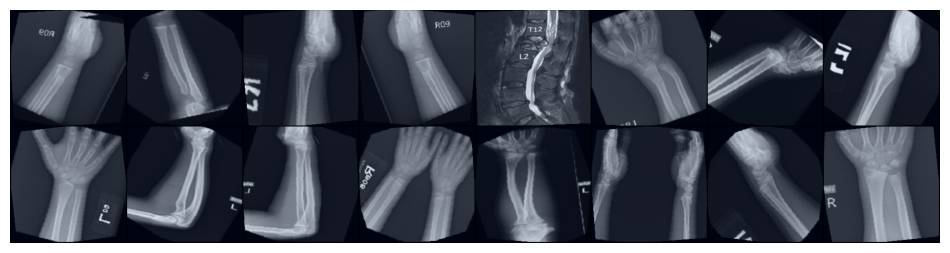

In [32]:
import matplotlib.pyplot as plt
import torchvision

grid = torchvision.utils.make_grid(xb[:16].cpu(), nrow=8, padding=2, normalize=True)
plt.figure(figsize=(12,4))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.show()


## 7. Funções de Treino e Validação {#sec-funcoes}

Funções reutilizáveis para uma época completa: *forward*, cálculo do `loss`, *backprop* (quando `train=True`) e métricas (accuracy, F1, AUC). A avaliação roda sem gradiente.


In [33]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from torch.amp import autocast, GradScaler

def run_epoch(dl, model, train: bool):
    model.train(train)
    all_preds, all_probs, all_targets = [], [], []
    running_loss = 0.0
    scaler = GradScaler(enabled=(device.type=="cuda"))

    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=(device.type=="cuda")):
            logits = model(xb)
            loss = criterion(logits, yb)

        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        running_loss += loss.item() * xb.size(0)

        probs = torch.softmax(logits.detach(), dim=1)[:,1].cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        all_probs.extend(probs.tolist())
        all_preds.extend(preds.tolist())
        all_targets.extend(yb.cpu().numpy().tolist())

    epoch_loss = running_loss / len(dl.dataset)
    acc = accuracy_score(all_targets, all_preds)
    f1  = f1_score(all_targets, all_preds)
    try:
        auc = roc_auc_score(all_targets, all_probs)
    except Exception:
        auc = float("nan")
    return epoch_loss, acc, f1, auc

def evaluate(dl, model):
    model.eval()
    with torch.no_grad():
        return run_epoch(dl, model, train=False)


## 8. Treinamento (Loop de Épocas) {#sec-treino}

Loop principal de treinamento. Reportamos `loss/acc/F1/AUC` para `train` e `val`. Adotamos **early stopping** baseado em AUC e salvamos o melhor modelo.


In [34]:
import math
best_val_auc = -math.inf
patience, bad = 3, 0
EPOCHS = 5  # começamos curto; podemos aumentar depois

for epoch in range(1, EPOCHS+1):
    train_loss, train_acc, train_f1, train_auc = run_epoch(train_dl, model, train=True)
    val_loss,   val_acc,   val_f1,   val_auc   = evaluate(val_dl, model)

    scheduler.step()

    print(f"[{epoch:02d}] "
          f"train: loss {train_loss:.4f} acc {train_acc:.4f} f1 {train_f1:.4f} auc {train_auc:.4f} | "
          f"val: loss {val_loss:.4f} acc {val_acc:.4f} f1 {val_f1:.4f} auc {val_auc:.4f}")

    # early stopping por AUC
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        bad = 0
        torch.save(model.state_dict(), "/kaggle/working/best_efficientnet_b0.pt")
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[01] train: loss 0.0024 acc 0.9995 f1 0.9995 auc 1.0000 | val: loss 0.0120 acc 0.9940 f1 0.9949 auc 0.9999


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[02] train: loss 0.0028 acc 0.9994 f1 0.9994 auc 1.0000 | val: loss 0.0088 acc 0.9988 f1 0.9990 auc 1.0000


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[03] train: loss 0.0012 acc 0.9999 f1 0.9999 auc 1.0000 | val: loss 0.0056 acc 0.9988 f1 0.9990 auc 1.0000


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[04] train: loss 0.0011 acc 0.9997 f1 0.9997 auc 1.0000 | val: loss 0.0063 acc 0.9976 f1 0.9980 auc 1.0000


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[05] train: loss 0.0007 acc 0.9999 f1 0.9999 auc 1.0000 | val: loss 0.0051 acc 0.9976 f1 0.9980 auc 1.0000


## 9. Checkpoint / Melhor Modelo {#sec-checkpoint}

Persistimos o melhor estado do modelo durante o treino (geralmente por AUC/val). Isso permite reprodutibilidade e avaliação posterior em `test`. 


In [35]:
# carregar melhor checkpoint se ainda não carregou
model.load_state_dict(torch.load("/kaggle/working/best_efficientnet_b0.pt", map_location=device))

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import torch

model.eval()
all_probs, all_preds, all_tgts = [], [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        all_probs.extend(probs.tolist())
        all_preds.extend(preds.tolist())
        all_tgts.extend(yb.numpy().tolist())

all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_tgts  = np.array(all_tgts)

print("=== CLASSIFICATION REPORT (test) ===")
print(classification_report(all_tgts, all_preds, target_names=["fractured","not fractured"]))

cm = confusion_matrix(all_tgts, all_preds)
cm


=== CLASSIFICATION REPORT (test) ===
               precision    recall  f1-score   support

    fractured       1.00      0.98      0.99       238
not fractured       0.99      1.00      0.99       268

     accuracy                           0.99       506
    macro avg       0.99      0.99      0.99       506
 weighted avg       0.99      0.99      0.99       506



array([[234,   4],
       [  0, 268]])

## 11. Visualizações: Matriz de Confusão e ROC {#sec-plots}

Plotamos a **matriz de confusão** para interpretar acertos/erros e a **curva ROC** com AUC para avaliar separação entre classes.


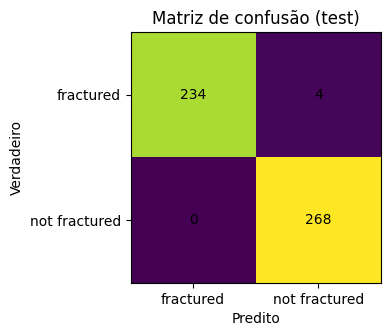

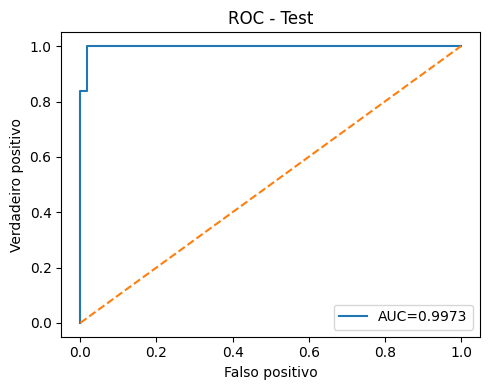

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion Matrix
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusão (test)")
plt.xticks([0,1], ["fractured","not fractured"])
plt.yticks([0,1], ["fractured","not fractured"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.xlabel("Predito"); plt.ylabel("Verdadeiro")
plt.tight_layout()
plt.show()

# ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(all_tgts, all_probs)
roc_auc = roc_auc_score(all_tgts, all_probs)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("Falso positivo"); plt.ylabel("Verdadeiro positivo"); plt.title("ROC - Test")
plt.legend(); plt.tight_layout(); plt.show()


## 13. Erros Típicos (FP/FN) {#sec-erros}

Listamos amostras **FP** e **FN** com *thumbnails* e probabilidades. Isso ajuda a identificar padrões de erro (ex.: recortes, artefatos, baixa exposição).


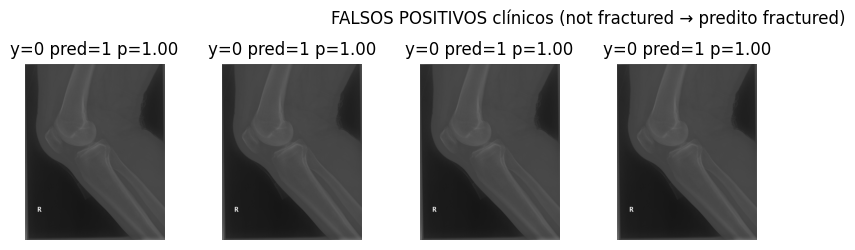

<Figure size 1200x0 with 0 Axes>

In [37]:
# coletar caminhos dos arquivos na mesma ordem do test_ds
test_paths = [p[0] for p in test_ds.samples]  # ImageFolder guarda (path,label)

fp_idx = np.where((all_tgts==0) & (all_preds==1))[0]  # fractured -> predito not? (ajuste conforme class_to_idx)
fn_idx = np.where((all_tgts==1) & (all_preds==0))[0]  # not fractured -> predito fractured?

# cuidado: seu class_to_idx é {'fractured':0, 'not fractured':1}
# então: 
#   FP (classe 0, predito 1) = "fractured predito not fractured" (falso negativo clínico)
#   FN (classe 1, predito 0) = "not fractured predito fractured" (falso positivo clínico)

def show_examples(idxs, title, n=12):
    import math
    from PIL import Image
    n = min(n, len(idxs))
    cols = 6
    rows = math.ceil(n/cols)
    plt.figure(figsize=(12, 2.5*rows))
    for i, k in enumerate(idxs[:n]):
        img = Image.open(test_paths[k]).convert("RGB")
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(f"y={all_tgts[k]} pred={all_preds[k]} p={all_probs[k]:.2f}")
        plt.axis("off")
    plt.suptitle(title); plt.tight_layout(); plt.show()

show_examples(fp_idx, "FALSOS POSITIVOS clínicos (not fractured → predito fractured)")
show_examples(fn_idx, "FALSOS NEGATIVOS clínicos (fractured → predito not fractured)")


## 12. Embeddings (PCA/UMAP) — opcional {#sec-embeddings}

Extraímos embeddings da penúltima camada e projetamos em 2D (PCA/UMAP). Útil para inspecionar separabilidade das classes e outliers.


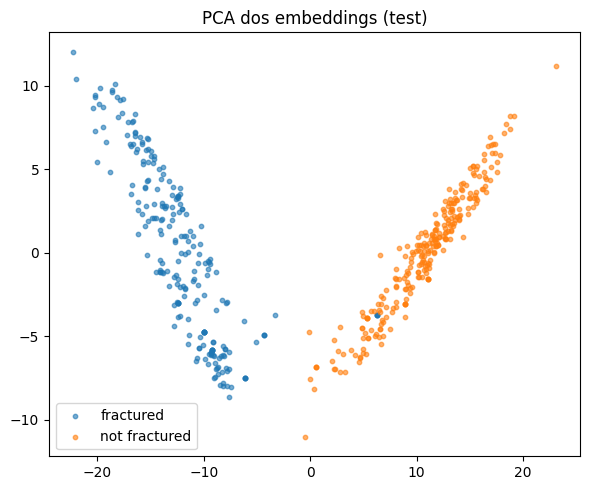

In [38]:
# capturar embeddings da penúltima camada (antes do Linear final)
import torch
from sklearn.decomposition import PCA

penultimate_feats = []

def hook_fn(module, inp, out):
    # Para EfficientNet-B0: a saída de model.avgpool é [B, 1280, 1, 1]; vamos fazer flatten
    # mas é mais simples hookar na camada "classifier[0]" (Dropout) e pegar o tensor que entra no Linear
    # Então vamos registrar hook na "classifier[1]" para pegar o input (features)
    pass

# Truque: criar um wrapper para capturar features antes do Linear
class FeatExtractor(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.backbone = torch.nn.Sequential(model.features, model.avgpool)  # extrai 1280x1x1
        self.flatten = torch.nn.Flatten(1)
    def forward(self, x):
        x = self.backbone(x)
        x = self.flatten(x)  # [B, 1280]
        return x

extractor = FeatExtractor(model).to(device)
extractor.eval()

X_emb, Y = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        feats = extractor(xb)          # [B, 1280]
        X_emb.append(feats.cpu().numpy())
        Y.extend(yb.numpy().tolist())

import numpy as np
X_emb = np.concatenate(X_emb, axis=0)
Y = np.array(Y)

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_emb)

plt.figure(figsize=(6,5))
for cls, label in [(0,"fractured"), (1,"not fractured")]:
    mask = (Y==cls)
    plt.scatter(Z[mask,0], Z[mask,1], s=10, alpha=0.6, label=label)
plt.title("PCA dos embeddings (test)"); plt.legend(); plt.tight_layout(); plt.show()

## 14. Resultados e Conclusões {#sec-conclusoes}

**Resumo do baseline:**  
- O modelo convergiu rapidamente e atingiu **alta acurácia** e **AUC próxima de 1.0** em validação.